In [42]:
!pip install matplotlib
!pip install seaborn



You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.


Sample type: 

Zuordnung:

{'First Metastasis': np.int64(0), 'First Recurrence': np.int64(1), 'Fourth recurrence': np.int64(2), 'Second Recurrence': np.int64(3), 'Third Recurrence': np.int64(4), 'Tumor Primary': np.int64(5)}
Random Forest Ergebnisse
Accuracy: 0.252

Confusion Matrix:
 [[ 0  0  0  0  0  0]
 [ 1 17  1 10  5 31]
 [ 0  1  0  0  0  0]
 [ 0  9  1  1  3  2]
 [ 0  1  0  1  0  0]
 [ 0 21  0 11  6 17]]

Classification Report:
                    precision    recall  f1-score   support

 First Metastasis       0.00      0.00      0.00         0
 First Recurrence       0.35      0.26      0.30        65
Fourth recurrence       0.00      0.00      0.00         1
Second Recurrence       0.04      0.06      0.05        16
 Third Recurrence       0.00      0.00      0.00         2
    Tumor Primary       0.34      0.31      0.32        55

         accuracy                           0.25       139
        macro avg       0.12      0.11      0.11       139
     weighted avg       0.30 

/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

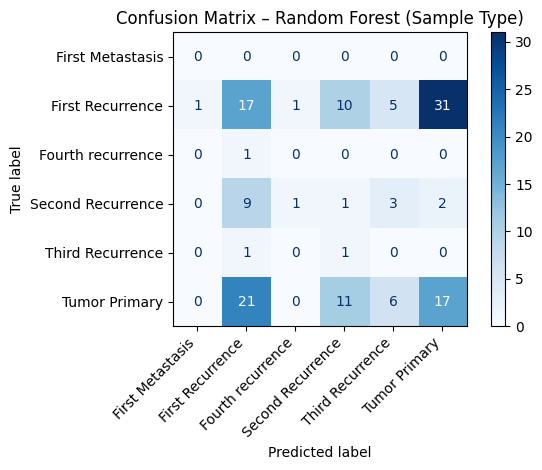

Logistic Regression Ergebnisse
Accuracy: 0.295

Confusion Matrix:
 [[ 0  0  0  0  0  0]
 [ 8  6  5 10  3 33]
 [ 0  0  0  0  0  1]
 [ 4  3  3  5  1  0]
 [ 0  0  0  0  2  0]
 [ 5  6  2  8  6 28]]

Classification Report:
                    precision    recall  f1-score   support

 First Metastasis       0.00      0.00      0.00         0
 First Recurrence       0.40      0.09      0.15        65
Fourth recurrence       0.00      0.00      0.00         1
Second Recurrence       0.22      0.31      0.26        16
 Third Recurrence       0.17      1.00      0.29         2
    Tumor Primary       0.45      0.51      0.48        55

         accuracy                           0.29       139
        macro avg       0.21      0.32      0.20       139
     weighted avg       0.39      0.29      0.29       139



/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nina/Schreibtisch/HCI/Projekt/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

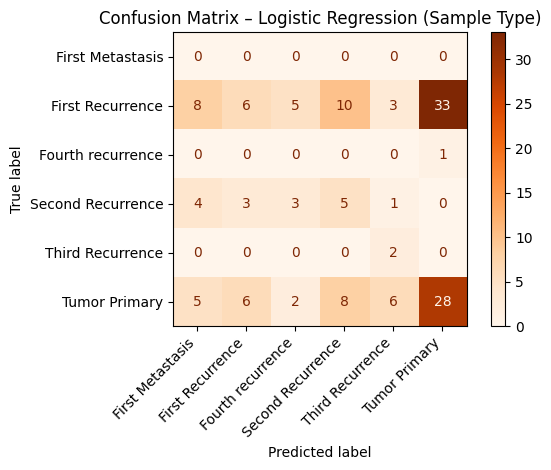

In [47]:





clinical_data = pd.read_csv("hcai_data-main/difg_glass_clinical_data_reduced.tsv.txt", sep="\t")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#print("Part 1:")
#print(clinical_data.shape)
#print(clinical_data.columns[:10])  #ersten 10 Spalten


##### auf sample type klassifizieren
print("Sample type: \n")
#print(clinical_data["Sample Type"])
clinical_data = clinical_data.dropna(subset=["Sample Type"]) #leere werte dropen
#survival columns dropen
clinical_data= clinical_data.drop("Overall Survival", axis='columns')
clinical_data= clinical_data.drop("Overall Survival (months)", axis='columns')
#print(clinical_data)
#labels: First Metastasis, Tumor Primary, First Recurrence, Second Recurrence, Third Recurrence, Fourth recurrence

# extract data from overal survival
'''def extract_survival_class(val):
    try:
        return int(str(val).split(":")[0])  # nimmt 0 oder 1
    except:
        return np.nan

clinical_data["Survival_Class"] = clinical_data["Overall Survival"].apply(extract_survival_class)
'''
# 
cols = [
    "Sample Type",
    "Cancer Type Detailed"
]
df = clinical_data[cols].copy()

# handle nan values
#df["Age"] = df["Age"].fillna(df["Age"].median())
#df["Radiation Dose"] = df["Radiation Dose"].fillna(0)


df_encoded = pd.get_dummies(df,
    columns=[
              "Cancer Type Detailed"],
    drop_first=True
)

#label encoder verwenden, damit z.B. 0 = First Recurrence
encoder = LabelEncoder()
y = encoder.fit_transform(df_encoded["Sample Type"])
print("Zuordnung:\n")
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

X = df_encoded.drop(columns=["Sample Type"])#features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train - random forest
model = RandomForestClassifier(class_weight="balanced",random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Random Forest Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


#ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=encoder.classes_, cmap='Blues')
labels = unique_labels(y_test, y_pred)
class_names = encoder.inverse_transform(labels)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=encoder.classes_))


#ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, display_labels=encoder.classes_, cmap='Oranges')
labels_log = unique_labels(y_test, y_pred_log)
class_names_log = encoder.inverse_transform(labels_log)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_log,
                            labels=labels_log,
                            target_names=class_names_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=class_names_log,
    cmap='Oranges'
)
plt.title("Confusion Matrix – Logistic Regression (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#y = df_encoded["Sample Type"] #target

clinical_data = pd.read_csv("hcai_data-main/difg_glass_clinical_data.tsv", sep="\t")
##### auf sample type klassifizieren
print("Sample type: \n")
#print(clinical_data["Sample Type"])
clinical_data = clinical_data.dropna(subset=["Sample Type"]) #leere werte dropen
#print(clinical_data)
#labels: Tumor Primary, First Recurrence, Second Recurrence, Third Recurrence, Fourth recurrence

cols = [
    "Sample Type", "Age","Cancer Type", "Cancer Type Detailed"
]
df = clinical_data[cols].copy()

# handle nan values
df["Age"] = df["Age"].fillna(df["Age"].median())
#df["Radiation Dose"] = df["Radiation Dose"].fillna(0)


df_encoded = pd.get_dummies(df,
    columns=[
             "Cancer Type", "Cancer Type Detailed"],
    drop_first=True
)

#label encoder verwenden, damit z.B. 0 = First Recurrence
encoder = LabelEncoder()
y = encoder.fit_transform(df_encoded["Sample Type"])
print("Zuordnung:\n")
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

X = df_encoded.drop(columns=["Sample Type"])#features


#######################################################################################################################################################

#K-Means

#######################################################################################################################################################

kmeans = KMeans(n_clusters=5, random_state=42)  #5 sample types: Tumor Primary, First Recurrence, Second Recurrence, Third Recurrence, Fourth recurrence
clusters = kmeans.fit_predict(X)

X["Cluster"] = clusters

# labels nicht encoded
df_analysis = df_encoded.copy()
df_analysis["Cluster"] = clusters
df_analysis["Sample Type"] = df["Sample Type"].values

#-----comparison Cluster vs. Sample Type------#
#crosstab computes a simple cross tabulation of two (or more) factors
crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type"], normalize='index')
print("Cluster vs. Sample Type\n")
print("Rounded crosstab value", crosstab.round(2))
crosstab.plot(kind='bar', stacked=False, colormap='plasma', figsize=(10,6))
plt.title("K-Means Clusters vs. Sample Type")
plt.ylabel("Percentage of Sample Type within Cluster")
plt.xlabel("Cluster")
plt.legend(title="Sample Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#number of each Sample Types per cluster 
raw_crosstab = pd.crosstab(df_analysis["Cluster"], df_analysis["Sample Type"])
print("Number of samples per cluster\n")
print(raw_crosstab)

#######################################################################################################################################################

#K-Means outcome: it's finding some patterns

#######################################################################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train - random forest
model = RandomForestClassifier(class_weight="balanced",random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix – Random Forest (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Ergebnisse")
print("Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log, target_names=encoder.classes_))

ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, display_labels=encoder.classes_, cmap='Oranges')
plt.title("Confusion Matrix – Logistic Regression (Sample Type)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
